In [1]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import epsAM as net
from function import adaptive_instance_normalization, coral
import glob
from itertools import product
import time
import cv2
import numpy as np

In [2]:
content_size = 512
style_size = 512

def test_transform(size, crop=False):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    if crop:
        transform_list.append(transforms.CenterCrop(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

In [5]:
def get_images(eps, epoch=160000):
    model_path = f'iter_{epoch}.pth.tar'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    vgg = net.get_vgg()
    decoder = net.get_decoder()
    model = net.Net(vgg, decoder, eps=eps).to(device)

    weights = torch.load(model_path, map_location='cpu')['model']
    weights = {k.replace('module.', ''): v for k, v in weights.items()}
    model.load_state_dict(weights)

    content_tf = test_transform(content_size)
    style_tf = test_transform(style_size)
    
    out_dir = 'result'
    os.makedirs(out_dir, exist_ok=True)
    for content_path, style_path in product(content_paths, style_paths):
        content_name = Path(os.path.basename(str(content_path))).stem
        style_name = Path(os.path.basename(str(style_path))).stem
        
        content = content_tf(Image.open(str(content_path))).unsqueeze(0)
        style = style_tf(Image.open(str(style_path))).unsqueeze(0)
        
        with torch.no_grad():
            output = model(content.to(device), style.to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy().clip(0, 1)
            output = (output * 255).astype(np.uint8)
            this_out_name = os.path.join(out_dir, f'{content_name}-{style_name}-{eps}.jpg')
            cv2.imwrite(this_out_name, output[...,::-1])

In [6]:
content_paths = ['input/content/chicago.jpg']
style_paths = glob.glob('input/style/la_muse.jpg')
eps_list = [1., 0.1, 0.01, 0.001]
for eps in eps_list:
    get_images(eps)

INFO: ada assignment
INFO: ada assignment
INFO: ada assignment
INFO: ada assignment
INFO: ada assignment


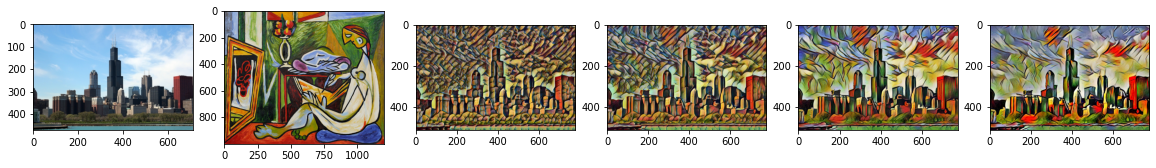

In [11]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv2.imread(content_paths[0])[...,::-1])
ax[1].imshow(cv2.imread(style_paths[0])[...,::-1])
for ax_idx, eps in enumerate(eps_list):
    ax[ax_idx+2].imshow(cv2.imread(
        f'result/chicago-la_muse-{eps}.jpg'
    )[...,::-1])